<a href="https://colab.research.google.com/github/swanny0000/ZTM-TensorFlow/blob/master/03_convolutional_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks

What are conputer vision problems?
* Binary classification - is this pizza or steak?
* Multi-class classification - is this sushi, steak, or pizza?
* Object detection - where is the thing in here?

Let's take a look at a pizza_steak dataset and use a convolutional neural network to evaluate that binary classification problem, and then get into some fun...

---

BUT WAIT! What's a Convolutional Neural Network?
1. Just like neural networks, a CNN has a set of inputs (often pictures) and an input layer designed to ingest an input
2. CNNs have *convolution layers* intended to extract important features from an input. These can be 1-dimensional, 2-dimensional, or 3-dimensional convolutions, depending on the data you're dealing with (text, images, or 3D maps)
3. CNNs also have a *pooling layer* to reduce the dimensionality of our model features. E.g. the convolutional layers expand out the features, and the pooling layer identifies the most important features that have been identified.
4. CNNs then use one or more fully-connected output layers "Dense" to prepare the model to output it's prediction.

Note that CNNs have a WHOLE bunch of options when designing the model - stacks of convolutional and pooling layers on top of each other can widely impact the accuracy of the model.


In [1]:
# Let's get cracking
# Subset of food pictures from https://www.kaggle.com/datasets/dansbecker/food-101
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()


--2023-11-09 02:06:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.207, 172.217.194.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M  20.9MB/s    in 6.1s    

2023-11-09 02:06:37 (17.2 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



Look at our folder - we've got a pizza_steak folder with subfolders:
* test
  * pizza
  * steak
* train
  * pizza
  * steak

We'll start small, and eventually grow our model to incorporate more food types

In [2]:
# Let's inspect our data

!ls pizza_steak

test  train


In [3]:
# want through pizza_steak directory and count number of files
import os

for dirpath, dirnames, fnames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(fnames)} files in {dirpath}")

There are 2 directories and 0 files in pizza_steak
There are 2 directories and 0 files in pizza_steak/test
There are 0 directories and 250 files in pizza_steak/test/steak
There are 0 directories and 250 files in pizza_steak/test/pizza
There are 2 directories and 0 files in pizza_steak/train
There are 0 directories and 750 files in pizza_steak/train/steak
There are 0 directories and 750 files in pizza_steak/train/pizza


In [4]:
# let's create class names dynamically
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['pizza', 'steak'], dtype='<U5')

Image shape: (512, 512, 3)


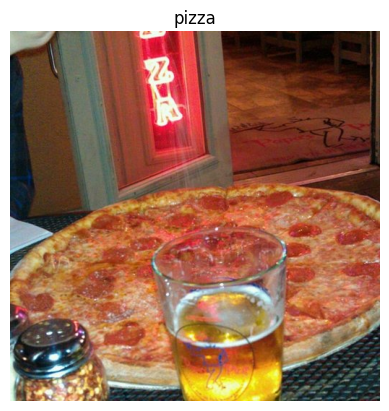

In [5]:
# let's visualize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")
  print(f"Image shape: {img.shape}")
  return img

img = view_random_image("pizza_steak/train/", "pizza")

Image shape: (384, 512, 3)


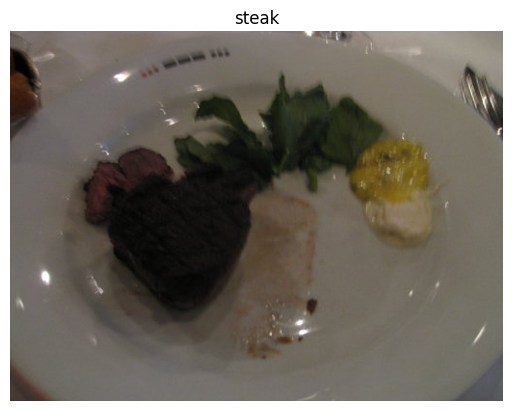

In [6]:
img = view_random_image("pizza_steak/train/", "steak")

Interesting... not all images are the same shape. How will we deal with that?

Also, these are RGB pictures - we'll need to normalize our data!

## An End-to-End Example
Let's:
1. Load our images into tensors
2. Preprocess our tensors
3. Build a CNN to find patterns in our tensors
4. Compile our CNN
5. Fit our CNN

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# set up paths to data directories
train_dir = "pizza_steak/train"
test_dir = "pizza_steak/test"

# import data and turn them into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(224,224), # reshape our tensors to a standard size
                                               class_mode="binary",
                                               seed=42)
valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224,224), # reshape our tensors to a standard size
                                               class_mode="binary",
                                               seed=42)

# build a cnn!
model_1 = tf.keras.Sequential()
model_1.add(tf.keras.layers.Conv2D(filters=10,
                                   kernel_size=3,
                                   activation="relu",
                                   input_shape=(224, 224, 3)))
model_1.add(tf.keras.layers.Conv2D(10, 3, activation="relu"))
model_1.add(tf.keras.layers.MaxPool2D(pool_size=2,
                                      padding="valid"))
model_1.add(tf.keras.layers.Conv2D(10, 3, activation="relu"))
model_1.add(tf.keras.layers.Conv2D(10, 3, activation="relu"))
model_1.add(tf.keras.layers.MaxPool2D(2))
model_1.add(tf.keras.layers.Flatten())
model_1.add(tf.keras.layers.Dense(1, activation="sigmoid"))

# compile the CNN
model_1.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer="Adam",
                metrics=["accuracy"])

# fit the CNN
history_1 = model_1.fit(train_data, #data and labels created automatically for us, thanks to the ImageDataGenerator
                        epochs=5,
                        steps_per_epoch=len(train_data), #47 batches of 32 images - this limits what the model looks at to save on RAM
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 27s 214ms/step - loss: 0.6153 - accuracy: 0.6653 - val_loss: 0.4181 - val_accuracy: 0.8400
Epoch 2/5
47/47 [==============================] - 7s 142ms/step - loss: 0.4681 - accuracy: 0.8000 - val_loss: 0.3699 - val_accuracy: 0.8580
Epoch 3/5
47/47 [==============================] - 11s 232ms/step - loss: 0.4080 - accuracy: 0.8233 - val_loss: 0.3424 - val_accuracy: 0.8600
Epoch 4/5
47/47 [==============================] - 13s 283ms/step - loss: 0.3708 - accuracy: 0.8393 - val_loss: 0.3404 - val_accuracy: 0.8680
Epoch 5/5
47/47 [==============================] - 9s 192ms/step - loss: 0.3218 - accuracy: 0.8660 - val_loss: 0.3326 - val_accuracy: 0.8600


note: if this is taking forever, turn on the GPUs!

CPU: `Epoch 1/5 47/47`
`[==============================] - 95s 2s/step`

GPU: `Epoch 1/5 47/47`
`[==============================] - 21s 162ms/step`


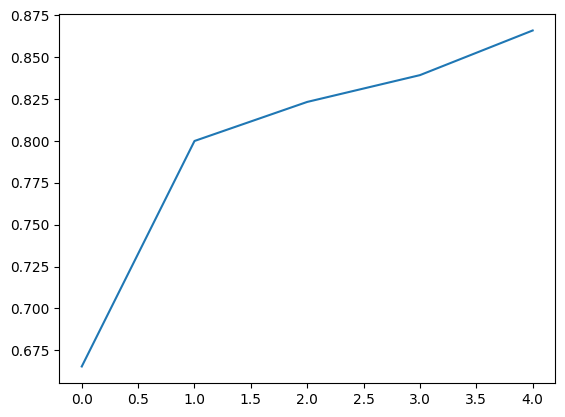

In [8]:
plt.plot(history_1.history["accuracy"])

In [9]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

we just created a CNN! how does it compare to https://poloclub.github.io/cnn-explainer/?

## Does a non-convolutional model work with image data?

Epoch 1/5
47/47 [==============================] - 8s 123ms/step - loss: 0.6936 - accuracy: 0.4960 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 6s 132ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 8s 171ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 8s 162ms/step - loss: 0.6932 - accuracy: 0.4707 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 9s 189ms/step - loss: 0.6932 - accuracy: 0.4747 - val_loss: 0.6931 - val_accuracy: 0.5000


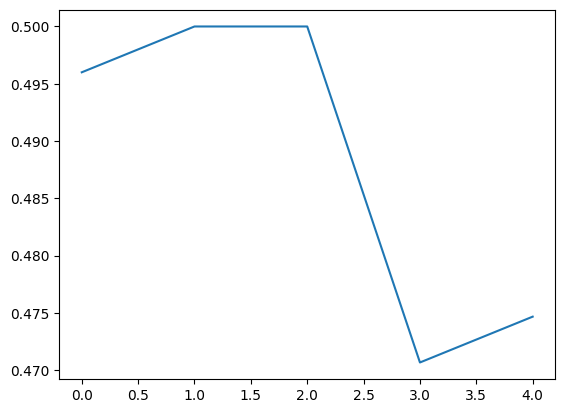

In [10]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Flatten(input_shape=(224, 224, 3)))
model_2.add(tf.keras.layers.Dense(4, activation="relu"))
model_2.add(tf.keras.layers.Dense(4, activation="relu"))
model_2.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model_2.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer="Adam",
                metrics=["accuracy"])

history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

plt.plot(history_2.history["accuracy"])

woof... not great. It's basically just guessing. How can we improve?

In [11]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 602116    
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602141 (2.30 MB)
Trainable params: 602141 (2.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


600k parameters vs a CNN's 30k parameters... but the CNN was much better!

Epoch 1/5
47/47 [==============================] - 11s 178ms/step - loss: 2.8126 - accuracy: 0.6367 - val_loss: 0.6395 - val_accuracy: 0.7000
Epoch 2/5
47/47 [==============================] - 8s 182ms/step - loss: 0.9076 - accuracy: 0.7060 - val_loss: 0.9342 - val_accuracy: 0.6160
Epoch 3/5
47/47 [==============================] - 7s 155ms/step - loss: 0.5351 - accuracy: 0.7640 - val_loss: 1.1899 - val_accuracy: 0.6380
Epoch 4/5
47/47 [==============================] - 8s 180ms/step - loss: 0.7673 - accuracy: 0.7187 - val_loss: 0.6437 - val_accuracy: 0.6960
Epoch 5/5
47/47 [==============================] - 5s 113ms/step - loss: 0.5160 - accuracy: 0.7800 - val_loss: 0.8358 - val_accuracy: 0.7260


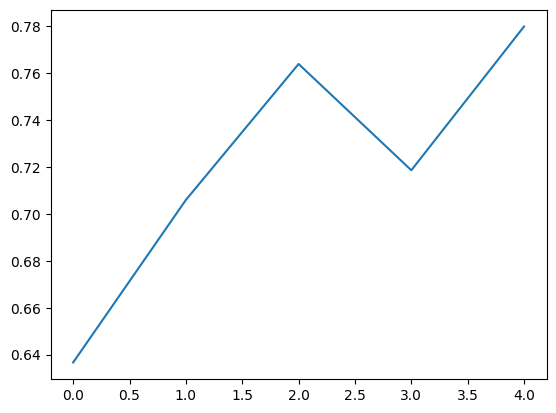

In [12]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.Flatten(input_shape=(224, 224, 3)))
model_3.add(tf.keras.layers.Dense(100, activation="relu"))
model_3.add(tf.keras.layers.Dense(100, activation="relu"))
model_3.add(tf.keras.layers.Dense(100, activation="relu"))
model_3.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model_3.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer="Adam",
                metrics=["accuracy"])

history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

plt.plot(history_3.history["accuracy"])

ok... it's getting there... but still not great :(

In [13]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 100)               15052900  
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15073201 (57.50 MB)
Trainable params: 15073201 (57.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


*and it took 15m parameters??* CNNs are a much better option for computer vision problems, even if a regular model will eventually learn patterns

## Let's break down Binary Classification

1. Become one with the data
2. Preprocess the data (scaling, normalizing, and batching)
3. Create a model (and start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust parameters to improve the model (to beat our baseline)
7. Repeat until satisfied

### Become one with the data

Image shape: (512, 512, 3)
Image shape: (512, 512, 3)


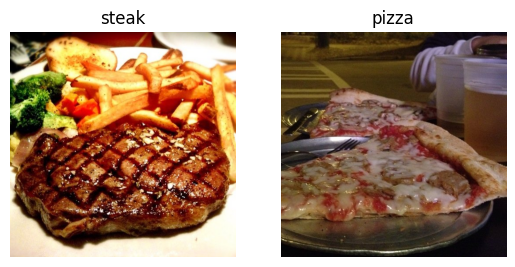

In [14]:
# Visualize!
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")

### Preprocess the data

In [15]:
from PIL import Image
# we're already got training and testing data
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

# turn our data into batches
#sinze these might be large images, the model can't take all of the images into memory at once
# trying to look at all of the images at once, rather than in smaller bits, could not result in very good learning rate
# common batch sizes are 16 or 32. DON"T GO ABOVE 32 (the guy who created these says it's bad for your health!)

# let's create train and test data generators and rescale teh data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [16]:
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(224, 224),
                                             class_mode="binary",
                                             batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [17]:
# get a sample of the training dataset
images, labels = train_data.next() # get the "next" batch of images/labels
len(images), len(labels)

(32, 32)

In [18]:
# how many batches are there?
len(train_data)

47

In [19]:
# what do the image tnsors look like?
images[:2], images[0].shape

(array([[[[0.47058827, 0.40784317, 0.34509805],
          [0.48627454, 0.42352945, 0.36078432],
          [0.48627454, 0.43529415, 0.37254903],
          ...,
          [0.82745105, 0.7137255 , 0.48627454],
          [0.8431373 , 0.7372549 , 0.5294118 ],
          [0.87843144, 0.77647066, 0.58431375]],
 
         [[0.50980395, 0.427451  , 0.36078432],
          [0.5058824 , 0.42352945, 0.35686275],
          [0.5137255 , 0.4431373 , 0.3647059 ],
          ...,
          [0.82745105, 0.7058824 , 0.48235297],
          [0.82745105, 0.70980394, 0.49803925],
          [0.8431373 , 0.73333335, 0.5372549 ]],
 
         [[0.5254902 , 0.427451  , 0.34901962],
          [0.5372549 , 0.43921572, 0.36078432],
          [0.5372549 , 0.45098042, 0.36078432],
          ...,
          [0.82745105, 0.7019608 , 0.4784314 ],
          [0.82745105, 0.7058824 , 0.4901961 ],
          [0.8352942 , 0.7176471 , 0.5137255 ]],
 
         ...,
 
         [[0.77647066, 0.5647059 , 0.2901961 ],
          [0.77647

In [20]:
labels

array([1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

### Let's build a CNN!

Our baseline: relatively simple model or existing result that you try to beat as you develop your model

In [21]:
# there's an easier way to write our code...
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [22]:
# Create our model
model_4 = Sequential()
model_4.add(Conv2D(filters=10,
                   kernel_size=3,
                   strides=1,
                   padding="valid",
                   activation="relu",
                   input_shape=(224, 224, 3)))
model_4.add(Conv2D(10, 3, activation="relu"))
model_4.add(Conv2D(10, 3, activation="relu"))
model_4.add(Flatten())
model_4.add(Dense(1, activation="sigmoid"))
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_3 (Flatten)         (None, 475240)            0         
                                                                 
 dense_8 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477341 (1.82 MB)
Trainable params: 477341 (1.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


what's actually going on in those convolutional layers?
Conv2D
* Filters: how many filters/sliding windows should pass over an input tensor? Typical values 10, 32, 64, 128... the more you have, the more complex your model
* Kernel size: square of how big our filters are. lower values learn smaller feature, larger values learn larger features
* Strides: number of steps the filter takes across an image at a time. Typically 1 or 2. Can allow you to only retain the most important information.
* Padding: Pads the target tensor with zeroes (if "same") to preserve input shape, or lowers the output shape (if "valid") due to convolutional overlap at start and end. Typically, you want to use "same".

More info: https://poloclub.github.io/cnn-explainer/

In [23]:
# compile our model
model_4.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

### Fit our model!

In [24]:
history_4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 10s 175ms/step - loss: 0.5744 - accuracy: 0.7027 - val_loss: 0.4196 - val_accuracy: 0.8140
Epoch 2/5
47/47 [==============================] - 7s 142ms/step - loss: 0.4018 - accuracy: 0.8307 - val_loss: 0.5565 - val_accuracy: 0.7100
Epoch 3/5
47/47 [==============================] - 6s 138ms/step - loss: 0.2772 - accuracy: 0.8887 - val_loss: 0.3451 - val_accuracy: 0.8600
Epoch 4/5
47/47 [==============================] - 8s 180ms/step - loss: 0.1383 - accuracy: 0.9613 - val_loss: 0.3454 - val_accuracy: 0.8460
Epoch 5/5
47/47 [==============================] - 9s 183ms/step - loss: 0.0620 - accuracy: 0.9860 - val_loss: 0.3814 - val_accuracy: 0.8380


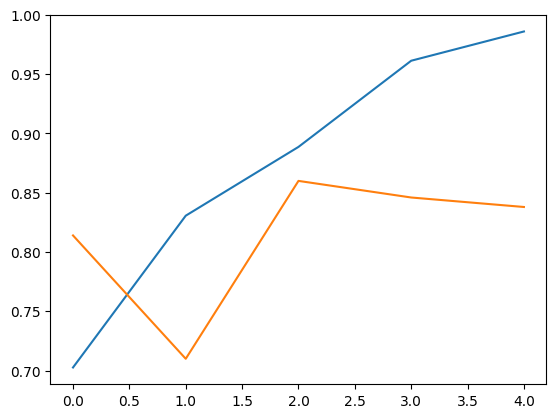

In [25]:
plt.plot(history_4.history["accuracy"])
plt.plot(history_4.history["val_accuracy"])

our training accuracy increase, but for some reason our test accuracy dropped a bit... what about our loss curves?

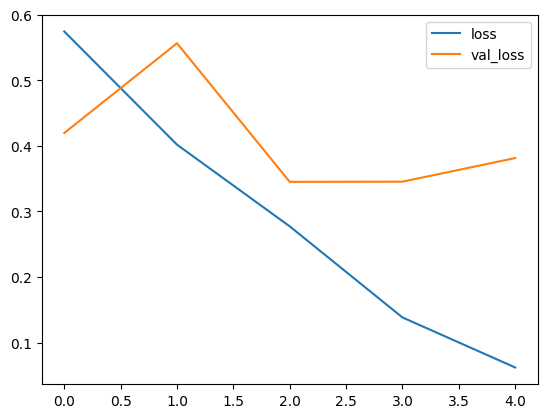

In [26]:
plt.plot(history_4.history["loss"], label="loss")
plt.plot(history_4.history["val_loss"], label="val_loss")
plt.legend()

In [27]:
def plot_history(history):
  plt.figure(figsize=(12,5))
  plt.subplot(1, 2, 1)
  plt.plot(history.history["loss"], label="loss")
  plt.plot(history.history["val_loss"], label="val_loss")
  plt.ylim(0,1)
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history["accuracy"], label="accuracy")
  plt.plot(history.history["val_accuracy"], label="val_accuracy")
  plt.ylim(0,1)
  plt.legend()

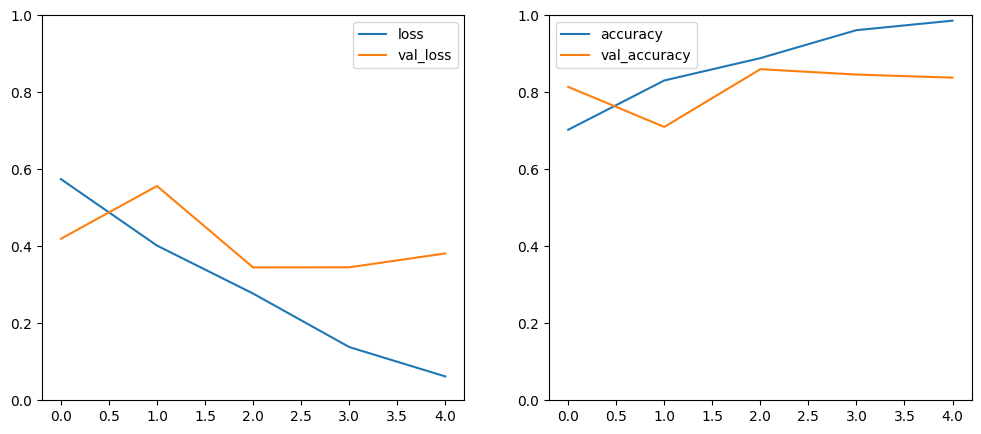

In [28]:
plot_history(history_4)

interesting how our validation loss isn't really going down very well...

In this case, it's likely that our model is **overfitting** the training dataset - it's learning our training dataset *too* well and isn't generalizeable beyond the training dataset. How can reduce overfitting?

### Reducing overfitting with max pooling
We can improve our models by:
0. Determining a baseline for our model
1. Creating a model to beat the baseline by overfitting
2. Reduce overfitting while still beating the baseline

How do we *induce* overfitting?
* Increase the number of convolutional layers
* increase the number of convolutional filters
* Adding dense layers before output layers

How do we *reduce* overfitting?
* Add data augmentation
* Add regularization layers like MaxPool2D
* Increase the amount of training data

***Note*** - "regularization" is essentially just us attempting to reduce overfitting!

In [29]:
from keras.src.engine.training import optimizer
tf.random.set_seed(42)
# Let's create a new baseline
model_5 = Sequential()
model_5.add(Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)))
model_5.add(MaxPool2D(pool_size=2))
model_5.add(Conv2D(10, 3, activation="relu"))
model_5.add(MaxPool2D())
model_5.add(Conv2D(10,3,  activation="relu"))
model_5.add(MaxPool2D())
model_5.add(Flatten())
model_5.add(Dense(1, activation="sigmoid"))

model_5.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

In [30]:
history_5 = model_5.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 7s 118ms/step - loss: 0.6594 - accuracy: 0.6007 - val_loss: 0.5133 - val_accuracy: 0.7620
Epoch 2/5
47/47 [==============================] - 10s 212ms/step - loss: 0.4888 - accuracy: 0.7667 - val_loss: 0.3865 - val_accuracy: 0.8460
Epoch 3/5
47/47 [==============================] - 10s 224ms/step - loss: 0.4405 - accuracy: 0.8060 - val_loss: 0.3581 - val_accuracy: 0.8400
Epoch 4/5
47/47 [==============================] - 8s 165ms/step - loss: 0.4139 - accuracy: 0.8153 - val_loss: 0.3400 - val_accuracy: 0.8520
Epoch 5/5
47/47 [==============================] - 8s 174ms/step - loss: 0.3839 - accuracy: 0.8333 - val_loss: 0.3239 - val_accuracy: 0.8780


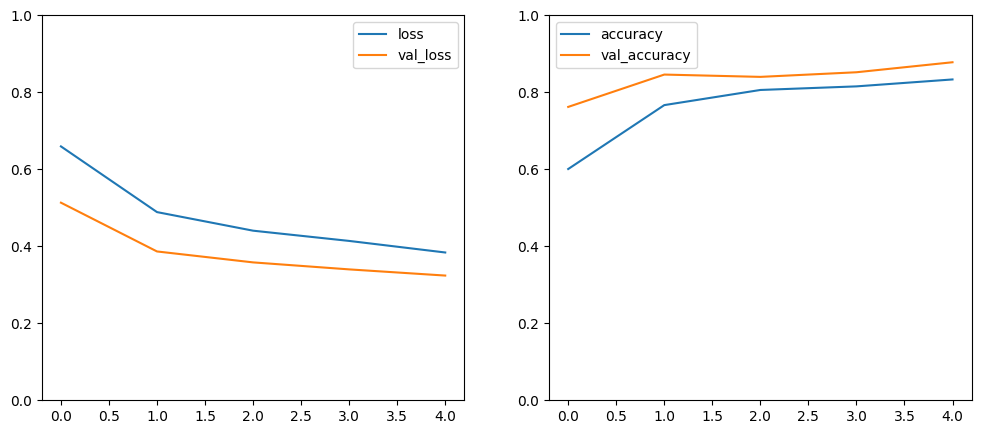

In [31]:
plot_history(history_5)

In [32]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 26, 26, 10)       

MUCH fewer parameters from Model 5, but it outperforms Model 4 thanks to the pooling layers!

### Using Data Augmentation
Data Augmentation is adding to our training dataset by intentionally modifying our training datasets with "minor" changes - for images, cropping, rotating, flipping, etc

In [33]:
# Let's revisit our datagenerators...
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=.2,
                                             shear_range=.2,
                                             zoom_range=.2,
                                             width_shift_range=.2,
                                             height_shift_range=.2,
                                             horizontal_flip=True)

# reinstatiate existing datagenerators that we have above
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [34]:
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode="binary",
                                                                   shuffle=False) #for now, set to false to prove a point

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode="binary",
                                               shuffle=False) #for now, set to false to prove a point

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode="binary",
                                             shuffle=False) #for now, set to false to prove a point

Found 1500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


Typically, you should only perform data augmentation on training data. You can use the `ImageDataGenerator` to modify images when creating your training tensors without modifying the actual files that you collected for training and testing.

In [35]:
# get sample data batches
images, labels = train_data.next()
images_augmented, labels_augmented = train_data_augmented.next()

(-0.5, 223.5, 223.5, -0.5)

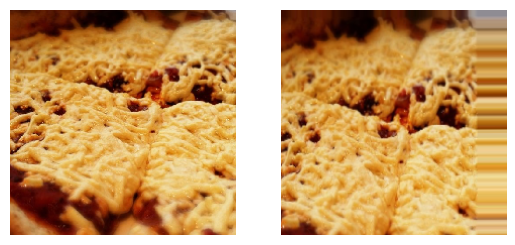

In [36]:
# show random images
random_number = random.randint(0, len(images))
plt.subplot(1, 2, 1)
plt.imshow(images[random_number])
plt.axis(False)
plt.subplot(1, 2, 2)
plt.imshow(images_augmented[random_number])
plt.axis(False)

Epoch 1/5
47/47 [==============================] - 34s 671ms/step - loss: 0.7098 - accuracy: 0.4513 - val_loss: 0.6918 - val_accuracy: 0.5160
Epoch 2/5
47/47 [==============================] - 26s 546ms/step - loss: 0.6935 - accuracy: 0.5347 - val_loss: 0.6836 - val_accuracy: 0.5960
Epoch 3/5
47/47 [==============================] - 35s 749ms/step - loss: 0.7471 - accuracy: 0.5560 - val_loss: 0.6812 - val_accuracy: 0.5020
Epoch 4/5
47/47 [==============================] - 32s 670ms/step - loss: 0.6966 - accuracy: 0.5100 - val_loss: 0.6736 - val_accuracy: 0.5640
Epoch 5/5
47/47 [==============================] - 25s 522ms/step - loss: 0.6898 - accuracy: 0.5680 - val_loss: 0.6548 - val_accuracy: 0.6520


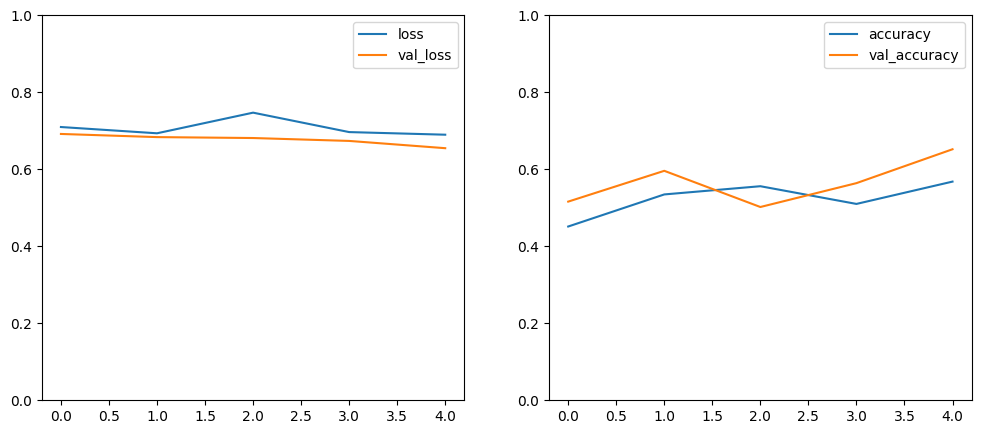

In [37]:
# what does our model with augmented data look like?
tf.random.set_seed(42)
model_6 = Sequential()
model_6.add(Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)))
model_6.add(MaxPool2D(pool_size=2))
model_6.add(Conv2D(10, 3, activation="relu"))
model_6.add(MaxPool2D())
model_6.add(Conv2D(10,3,  activation="relu"))
model_6.add(MaxPool2D())
model_6.add(Flatten())
model_6.add(Dense(1, activation="sigmoid"))

model_6.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

history_6 = model_6.fit(train_data_augmented,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

plot_history(history_6)

why did this take much longer to fit, and why isn't it getting the same accuracy or val_accuracy as model 5?
* Our training data stays the same, but our augmenting datagenerator takes longer because it modifies our data on the fly *each time*
* Lack of improvements may be because we've now made our data *too hard to fit to*. Perhaps we should slowly implement data generator augmentation one-by-one?

Found 1500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 24s 485ms/step - loss: 0.6604 - accuracy: 0.5873 - val_loss: 0.5280 - val_accuracy: 0.7740
Epoch 2/5
47/47 [==============================] - 23s 481ms/step - loss: 0.5250 - accuracy: 0.7587 - val_loss: 0.3984 - val_accuracy: 0.8240
Epoch 3/5
47/47 [==============================] - 24s 504ms/step - loss: 0.5015 - accuracy: 0.7653 - val_loss: 0.4307 - val_accuracy: 0.7960
Epoch 4/5
47/47 [==============================] - 23s 500ms/step - loss: 0.4792 - accuracy: 0.7767 - val_loss: 0.3742 - val_accuracy: 0.8300
Epoch 5/5
47/47 [==============================] - 22s 476ms/step - loss: 0.4613 - accuracy: 0.7853 - val_loss: 0.3323 - val_accuracy: 0.8640


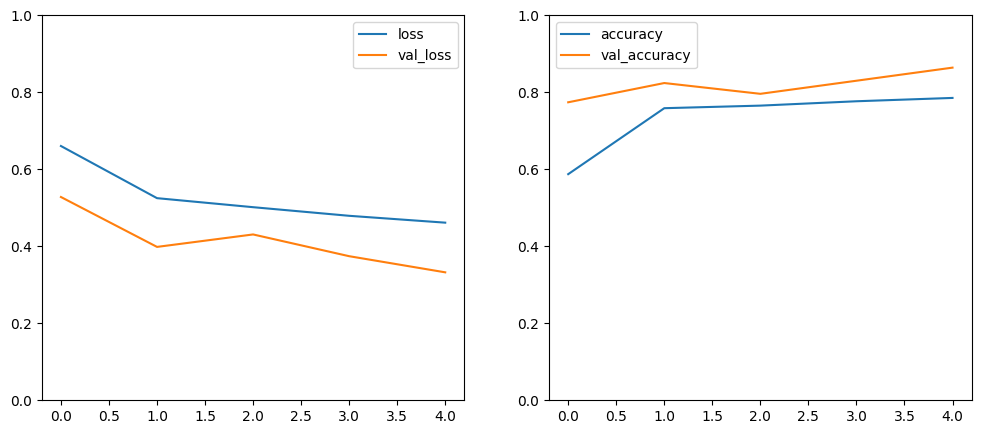

In [38]:
# what if we tried shuffling=True?
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                            target_size=(224, 224),
                                                                            batch_size=32,
                                                                            class_mode="binary",
                                                                            shuffle=True)

tf.random.set_seed(42)
model_7 = Sequential()
model_7.add(Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)))
model_7.add(MaxPool2D(pool_size=2))
model_7.add(Conv2D(10, 3, activation="relu"))
model_7.add(MaxPool2D())
model_7.add(Conv2D(10,3,  activation="relu"))
model_7.add(MaxPool2D())
model_7.add(Flatten())
model_7.add(Dense(1, activation="sigmoid"))

model_7.compile(loss="binary_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

history_7 = model_7.fit(train_data_augmented_shuffled,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

plot_history(history_7)

remember that our data is sorted into pizza first, and then steak - without shuffling, the model only uses pizza without looking at steak at all. WIth shuffling, the model looks at both options at once!

### What else could we improve on?
* Add more convolution/pooling layers
* Add more hidden units (filters in each convolution layer)
* Get more data and try fitting for longer
* Consider using transfer learning to start at a higher accuracy

In [39]:
# Making a prediction on our own custom data! How can we get an image stored on GitHub to predict on?
# https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/images/03-steak.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg


--2023-11-09 02:16:33--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg’

03-steak.jpeg       100%[===================>]   1.89M  --.-KB/s    in 0.009s  

2023-11-09 02:16:34 (221 MB/s) - ‘03-steak.jpeg’ saved [1978213/1978213]



In [40]:
import matplotlib.image as mpimg
steak = mpimg.imread("/content/03-steak.jpeg")

In [41]:
# cann we pass this directly to our model?
steak.shape

(4032, 3024, 3)

In [42]:
# let's write a helper function to do our prediction pre-processing
def load_and_prep_img(filename, img_shape=224):
  '''
  Reads an image from the filename and returns a tensor
  with dimensions (img_shape, img_shape, color_channels)
  '''
  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img)
  img = tf.image.resize(img, size=[img_shape, img_shape])
  img = img/255.
  return img


In [43]:
steak = load_and_prep_img("03-steak.jpeg")
pred = model_7.predict(tf.expand_dims(steak, axis=0))

1/1 [==============================] - 0s 194ms/step


array([[0.93007225]], dtype=float32)

prediction probability of a binary calculation, so it's most likely the "positive" class... but can we make that a human-readable output?

In [43]:
# index the predicted class by rounding the prediction
pred_class = class_names[int(tf.round(pred))]
pred_class

In [52]:
def pred_and_plot(model, filename, class_names=class_names):
  '''
  Imports a file, generate a prediction for the file using a given model, and then display the prediction
  '''
  image = load_and_prep_img(filename)
  pred = model.predict(tf.expand_dims(image, axis=0))
  pred_class = class_names[int(tf.round(pred))]
  plt.imshow(image)
  plt.axis(False)
  plt.title(f"Prediction: {pred_class} {tf.round(pred*1e4)/1e4}")

1/1 [==============================] - 0s 17ms/step


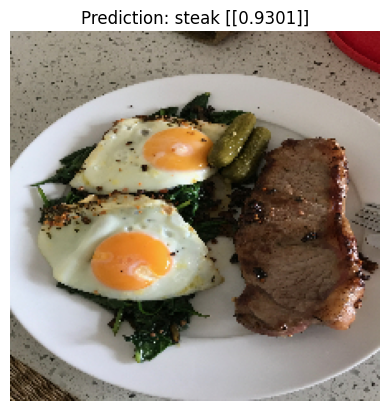

In [53]:
pred_and_plot(model_7, "03-steak.jpeg")

--2023-11-09 02:25:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg.1’

03-pizza-dad.jpeg.1 100%[===================>]   2.74M  --.-KB/s    in 0.02s   

2023-11-09 02:25:56 (181 MB/s) - ‘03-pizza-dad.jpeg.1’ saved [2874848/2874848]

1/1 [==============================] - 0s 28ms/step


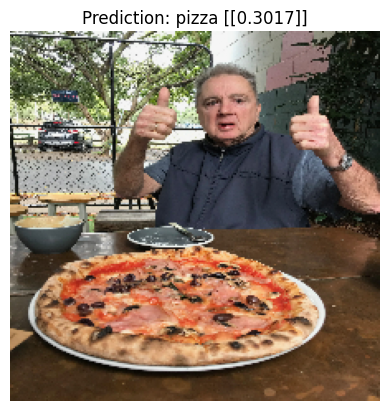

In [55]:
# what about a pizzadad?
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
pred_and_plot(model_7, "03-pizza-dad.jpeg")

Let's step it up... more foods, more classes.

## Multiclass Classification

1. Become one with the data
2. Preprocess the data
3. Create a baseline model
4. (Over)fit the model
5. Evaluate the model
6. Adjust hyperparameters to reduce overfitting
7. Repeat until satisfied

In [56]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
zipref = zipfile.ZipFile("10_food_classes_all_data.zip")
zipref.extractall()
zipref.close()

--2023-11-09 02:37:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.175.207, 74.125.24.207, 142.250.4.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.175.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  24.1MB/s    in 22s     

2023-11-09 02:37:37 (22.1 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [57]:
import os
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} files in {dirpath}")

There are 2 directories and 0 files in 10_food_classes_all_data
There are 10 directories and 0 files in 10_food_classes_all_data/test
There are 0 directories and 250 files in 10_food_classes_all_data/test/hamburger
There are 0 directories and 250 files in 10_food_classes_all_data/test/chicken_curry
There are 0 directories and 250 files in 10_food_classes_all_data/test/sushi
There are 0 directories and 250 files in 10_food_classes_all_data/test/steak
There are 0 directories and 250 files in 10_food_classes_all_data/test/fried_rice
There are 0 directories and 250 files in 10_food_classes_all_data/test/grilled_salmon
There are 0 directories and 250 files in 10_food_classes_all_data/test/chicken_wings
There are 0 directories and 250 files in 10_food_classes_all_data/test/ice_cream
There are 0 directories and 250 files in 10_food_classes_all_data/test/pizza
There are 0 directories and 250 files in 10_food_classes_all_data/test/ramen
There are 10 directories and 0 files in 10_food_classes_al

In [61]:
# train and test directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [62]:
# let's visualize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")
  print(f"Image shape: {img.shape}")
  return img

Image shape: (512, 512, 3)


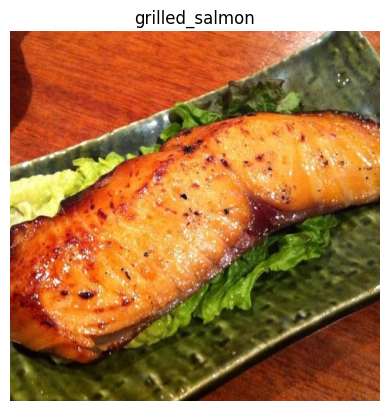

In [70]:
img = view_random_image(train_dir, random.choice(class_names))

In [76]:
# preprocess...
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               seed=42,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             seed=42,
                                             class_mode="categorical")

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [78]:
from keras.src.engine import sequential
# start fresh
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

model_8 = Sequential()
model_8.add(Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)))
model_8.add(Conv2D(10, 3, activation="relu"))
model_8.add(MaxPool2D())
model_8.add(Conv2D(10, 3, activation="relu"))
model_8.add(Conv2D(10, 3, activation="relu"))
model_8.add(MaxPool2D())
model_8.add(Flatten())
model_8.add(Dense(10, activation="softmax"))

model_8.compile(loss=CategoricalCrossentropy(),
                optimizer=Adam(),
                metrics=["accuracy"])

In [79]:
model_8.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 conv2d_17 (Conv2D)          (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 110, 110, 10)      0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 108, 108, 10)      910       
                                                                 
 conv2d_19 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 53, 53, 10)        0         
 ng2D)                                                

In [81]:
history_8 = model_8.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
235/235 [==============================] - 34s 130ms/step - loss: 2.1694 - accuracy: 0.1955 - val_loss: 2.0672 - val_accuracy: 0.2456
Epoch 2/5
235/235 [==============================] - 36s 151ms/step - loss: 1.8902 - accuracy: 0.3420 - val_loss: 1.8538 - val_accuracy: 0.3492
Epoch 3/5
235/235 [==============================] - 33s 141ms/step - loss: 1.5045 - accuracy: 0.5028 - val_loss: 2.0745 - val_accuracy: 0.3208
Epoch 4/5
235/235 [==============================] - 29s 124ms/step - loss: 0.8474 - accuracy: 0.7264 - val_loss: 2.4630 - val_accuracy: 0.2976
Epoch 5/5
235/235 [==============================] - 30s 128ms/step - loss: 0.2910 - accuracy: 0.9136 - val_loss: 3.5438 - val_accuracy: 0.2864


In [84]:
def plot_history(history):
  plt.figure(figsize=(12,5))
  plt.subplot(1, 2, 1)
  plt.plot(history.history["loss"], label="loss")
  plt.plot(history.history["val_loss"], label="val_loss")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history["accuracy"], label="accuracy")
  plt.plot(history.history["val_accuracy"], label="val_accuracy")
  plt.ylim(0,1)
  plt.legend()

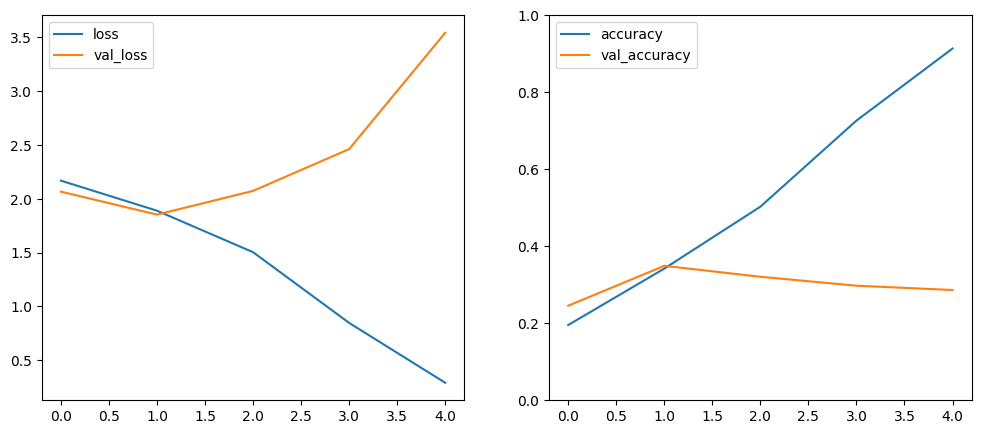

In [85]:
plot_history(history_8)

In [86]:
model_8.evaluate(test_data)

79/79 [==============================] - 9s 107ms/step - loss: 3.5438 - accuracy: 0.2864


[3.5438499450683594, 0.2863999903202057]

so... we're likely overfitting. That was our goal! Let's abstract out a bit.

Epoch 1/5
235/235 [==============================] - 26s 104ms/step - loss: 2.0628 - accuracy: 0.2675 - val_loss: 1.8959 - val_accuracy: 0.3281
Epoch 2/5
235/235 [==============================] - 23s 99ms/step - loss: 1.6750 - accuracy: 0.4367 - val_loss: 1.8587 - val_accuracy: 0.3609
Epoch 3/5
235/235 [==============================] - 23s 99ms/step - loss: 1.3159 - accuracy: 0.5692 - val_loss: 1.8446 - val_accuracy: 0.3656
Epoch 4/5
235/235 [==============================] - 27s 115ms/step - loss: 0.8642 - accuracy: 0.7376 - val_loss: 2.2666 - val_accuracy: 0.3094
Epoch 5/5
79/79 [==============================] - 7s 87ms/step - loss: 2.5764 - accuracy: 0.3264


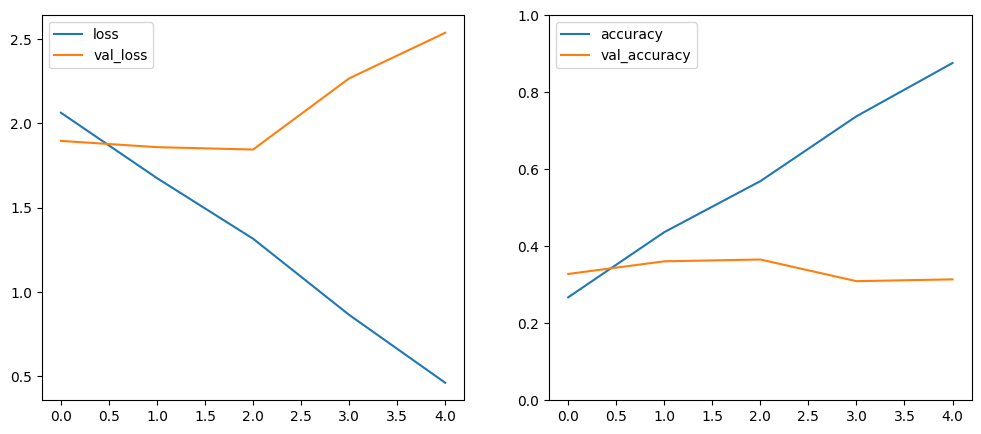

In [90]:
# Let's reduce the compexity of our model (fewer hidden layers)
model_9 = Sequential()
model_9.add(Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)))
model_9.add(MaxPool2D())
model_9.add(Conv2D(10, 3, activation="relu"))
model_9.add(MaxPool2D())
model_9.add(Flatten())
model_9.add(Dense(10, activation="softmax"))

model_9.compile(loss=CategoricalCrossentropy(),
                optimizer=Adam(),
                metrics=["accuracy"])

history_9 = model_9.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=.25*len(test_data))

model_9.evaluate(test_data)
plot_history(history_9)

not quite it... notice that the summary didn't actuall decrease the number of ovreall parameters (283920 vs 292800)

In [91]:
model_9.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 111, 111, 10)      0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 54, 54, 10)        0         
 ng2D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 29160)             0         
                                                                 
 dense_13 (Dense)            (None, 10)              

Found 7500 images belonging to 10 classes.
Epoch 1/5
235/235 [==============================] - 104s 434ms/step - loss: 2.1547 - accuracy: 0.1956 - val_loss: 2.0672 - val_accuracy: 0.2734
Epoch 2/5
235/235 [==============================] - 102s 436ms/step - loss: 1.8748 - accuracy: 0.3479 - val_loss: 1.7753 - val_accuracy: 0.3781
Epoch 3/5
235/235 [==============================] - 102s 436ms/step - loss: 1.7035 - accuracy: 0.4196 - val_loss: 1.9373 - val_accuracy: 0.3250
Epoch 4/5
235/235 [==============================] - 102s 435ms/step - loss: 1.5019 - accuracy: 0.5043 - val_loss: 1.9358 - val_accuracy: 0.3484
Epoch 5/5
79/79 [==============================] - 8s 104ms/step - loss: 2.0567 - accuracy: 0.3496


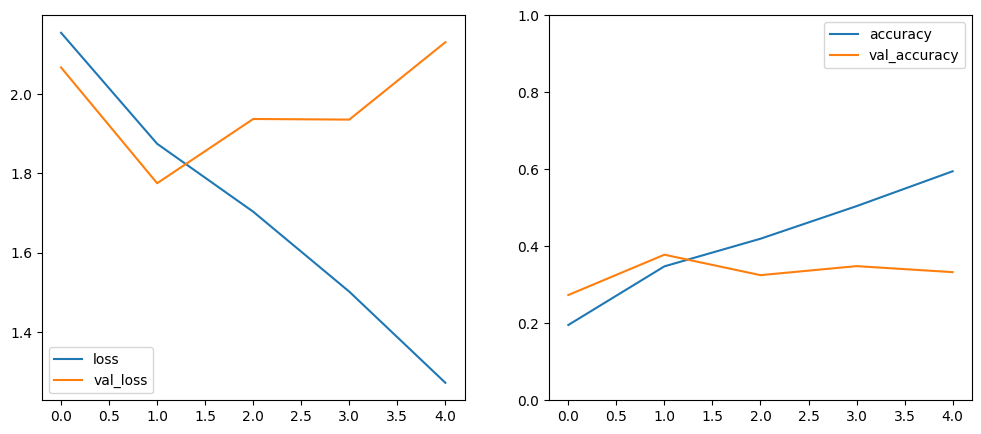

In [94]:
# how about data augmentation?
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=.2,
                                             shear_range=.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   seed=42,
                                                                   target_size=(224, 224))

model_10 = tf.keras.models.clone_model(model_8) # doesn't take any learned values

model_10.compile(loss=CategoricalCrossentropy(),
                 optimizer=Adam(),
                 metrics=["accuracy"])

history_10 = model_10.fit(train_data_augmented,
                          epochs=5,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=.25*len(test_data))

model_10.evaluate(test_data)
plot_history(history_10)

For further improvements, we could do a number of things...
* Tweak our `ImageDataGenerator` hyperparameters
* Get more data to train with
* Continue to tweak model parameters
* If loss and accuracy curves are following each other, train for longer
* Consider using transfer learning (next module)

For now, let's take a look at some other external images

In [100]:
def pred_and_plot(model, filename, class_names=class_names):
  '''
  Imports a file, generate a prediction for the file using a given model, and then display the prediction
  '''
  image = load_and_prep_img(filename)
  pred = model.predict(tf.expand_dims(image, axis=0))
  if len(pred[0])>1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[int(tf.round(pred))]
  plt.imshow(image)
  plt.axis(False)
  plt.title(f"Prediction: {pred_class} {tf.round(pred*1e4)/1e4}")

In [102]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg

--2023-11-09 04:11:12--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg.2’

03-pizza-dad.jpeg.2 100%[===================>]   2.74M  --.-KB/s    in 0.01s   

2023-11-09 04:11:13 (191 MB/s) - ‘03-pizza-dad.jpeg.2’ saved [2874848/2874848]

--2023-11-09 04:11:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, await

1/1 [==============================] - 0s 19ms/step


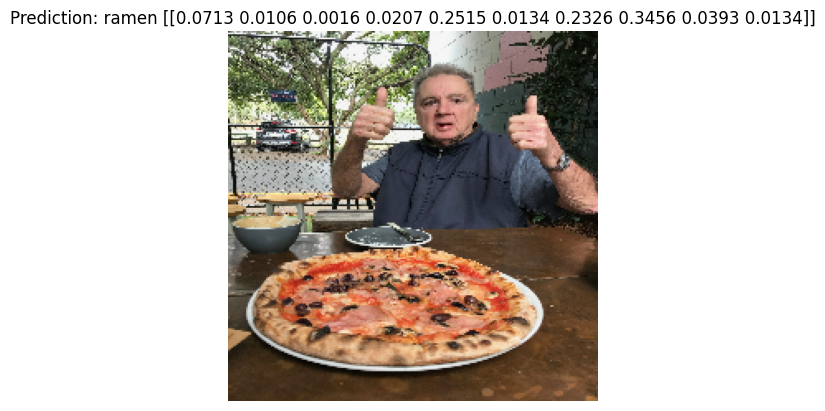

In [103]:
pred_and_plot(model_10, "03-pizza-dad.jpeg", list(class_names))

1/1 [==============================] - 0s 37ms/step


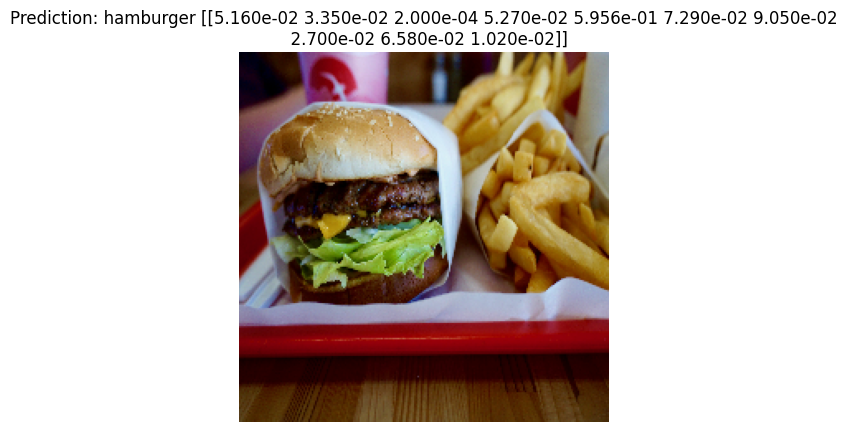

In [104]:
pred_and_plot(model_10, "03-hamburger.jpeg")

1/1 [==============================] - 0s 21ms/step


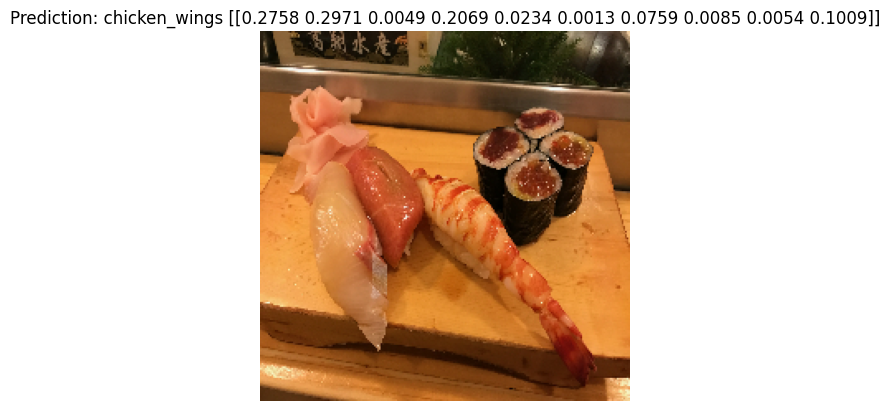

In [105]:
pred_and_plot(model_10, "03-sushi.jpeg")

1/1 [==============================] - 0s 41ms/step


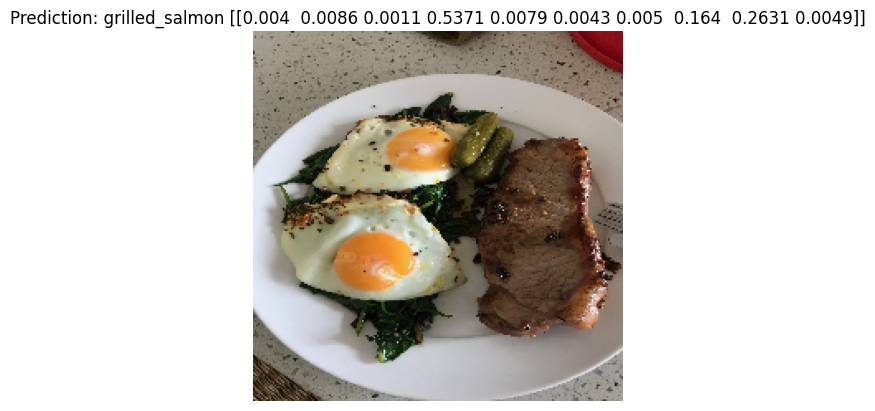

In [106]:
pred_and_plot(model_10, "03-steak.jpeg")

Not super great :(

Let's look at saving this one off in case we want to revisit it!

In [107]:
model_10.save("saved_trained_model_10")

In [108]:
# what does that saved model look like?
loaded_model_10 = tf.keras.models.load_model("saved_trained_model_10")
loaded_model_10.evaluate(test_data)
model_10.evaluate(test_data)

79/79 [==============================] - 8s 96ms/step - loss: 2.0567 - accuracy: 0.3496


[2.056698799133301, 0.3495999872684479]